## Откройте и изучите файл

In [1]:
!pip install -q --no-warn-script-location --upgrade pip 
!pip install -q --no-warn-script-location -U pandas numpy scikit-learn seaborn

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
import seaborn as sb
import numpy as np

In [3]:
sb.set_theme(
    font_scale=1.2,
    rc={'figure.figsize':(11.7,8.27),}
)

In [4]:
users_behavior = pd.read_csv(
    filepath_or_buffer='/datasets/users_behavior.csv', 
    dtype={'calls': 'int', 'messages': 'int', 'is_ultra': 'int'}
)
users_behavior.head()

,calls,minutes,messages,mb_used,is_ultra
0,40,311.90,83,19915.42,0
1,85,516.75,56,22696.96,0
2,77,467.66,86,21060.45,0
3,106,745.53,81,8437.39,1
4,66,418.74,1,14502.75,0


In [5]:
users_behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int64  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int64  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


In [6]:
users_behavior.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [7]:
n_ultra = users_behavior['is_ultra'].sum()
n_smart = users_behavior['is_ultra'].size - n_ultra
print(
    'Количество клиентов с тарифом смарт: {}'.format(n_smart),
    'Количество клиентов с тарифом ультра: {}'.format(n_ultra),
    'Соотношение количества пользователей тарифа смарт к тарифу ультра: {:.2f}'.format(n_smart/n_ultra),
    sep='\n'
)

Количество клиентов с тарифом смарт: 2229
Количество клиентов с тарифом ультра: 985
Соотношение количества пользователей тарифа смарт к тарифу ультра: 2.26


**Вывод**
- Похоже все значения действительно на месте.
- Типы переменных 'calls', 'messages', 'is_ultra' преобразованы к типу int при загрузке данных.
- Клиентские классы по тарифу не сбалансированны. Количество клиентов с тарифом ультра меньше количества клиентов с тарифом смарт в 2.26 раза. 

## Разбейте данные на выборки

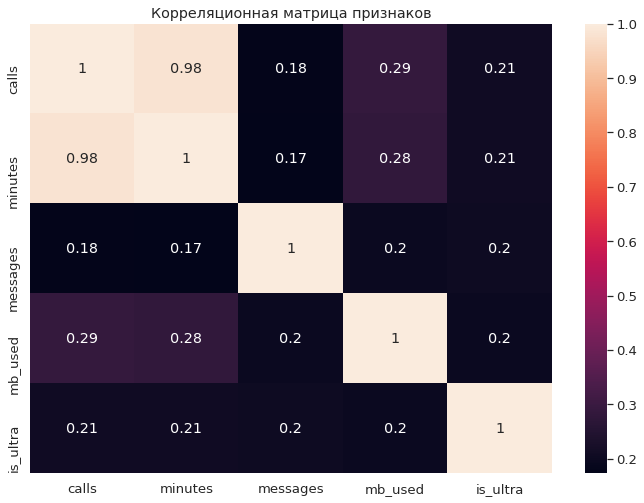

In [8]:
ax = sb.heatmap(users_behavior.corr(), annot=True)
_ = ax.set_title('Корреляционная матрица признаков')

Признаки calls и minutes находятся в сильной линейной зависимости. Коэффициент корреляции 0.98. Это означает, что один признак практически польностью объясняет другой. 


Наличие двух сильно скоррелированных признаков влечет избыточность информации и может оказывать сильное влияние на обучение некоторых моделей.

In [9]:
def split_summary(feature, target, name):
    print('Выборка:', name)
    print('Размеры пространства feature:', feature.shape)
    print('Размеры пространства target:', target.shape)
    print('Доли классов target:')
    for row in target.value_counts().iteritems():
        print('    target class: {} fraction: {:.2f}'.format(row[0], row[1] / target.size))
    print()

In [10]:
feature = users_behavior.drop(columns=['is_ultra']) #, 'calls'
target = users_behavior['is_ultra']

train_feature, checkup_feature, train_target, checkup_target = train_test_split(
    feature,
    target,
    test_size=.4, 
    stratify=target,
    random_state=12345
)
valid_feature, test_feature, valid_target, test_target = train_test_split(
    checkup_feature,
    checkup_target,
    test_size=.5, 
    stratify=checkup_target,
    random_state=12345
)
split_summary(train_feature, train_target, 'train')
split_summary(valid_feature, valid_target, 'valid')
split_summary(test_feature, test_target, 'test')

Выборка: train
Размеры пространства feature: (1928, 4)
Размеры пространства target: (1928,)
Доли классов target:
    target class: 0 fraction: 0.69
    target class: 1 fraction: 0.31

Выборка: valid
Размеры пространства feature: (643, 4)
Размеры пространства target: (643,)
Доли классов target:
    target class: 0 fraction: 0.69
    target class: 1 fraction: 0.31

Выборка: test
Размеры пространства feature: (643, 4)
Размеры пространства target: (643,)
Доли классов target:
    target class: 0 fraction: 0.69
    target class: 1 fraction: 0.31



Выше я применил функцию train_test_split дважды для разделения на три выборки train, test и valid. При разбиении я использовал параметр stratify, чтобы объекты разных классов во всех выборках были в одинаковых пропорциях. Иначе могло, например, случиться так, что в выборке train или не окажется или окажется очень мало представителей одного из классов и модель может просто научиться отвечать одно и то же (например выдавать всегда 0) на каждый вопрос.

**Вывод**

- Данные были разбиты на три выборки train, valid, test с использованием стратификации по классам.
- Выборку test откладываем для заключительной оценки качества.
- Признаки calls/minutes не удалял

## Исследуйте модели

Ниже я написал вспомогательный класс для поиска параметров
- инициализируется заданием выборок и типа sklearn.Estimator
- основной метод - seach_params
- есть свойства с типичными названиями scores, best_scores, best_params, params_grid, 
- свойство report отдает датафрейм с сеткой параметров и значений метрики
- остальные функции - вспомогательные 

In [11]:
class ParamsSearch:
    def __init__(self, train_feature, train_target, valid_feature, valid_target, estimator):
        # There is should be checkup of args in __future__ (лень чет)
        self.__estimator = estimator
        self.__train_feature = train_feature
        self.__train_target = train_target
        self.__valid_feature = valid_feature
        self.__valid_target = valid_target
        self.__scores = list()
        self.__params_grid = None
        self.__best_score = None
        self.__best_params = None
        self.model = None
        self.__fitted = False
        self.__best_score_changed = False
    
    @property
    def scores(self):
        return self.__scores
    
    def __update_scores(self, value):
        self.__scores.append(value)

    @property
    def best_score(self):
        return self.__best_score
    
    def __update_best_score(self, value):
        if (self.__best_score is None) or (self.__best_score < value):
            self.__best_score = value
            self.__best_score_changed = True
        else:
            self.__best_score_changed = False
    
    @property
    def best_params(self):
        return self.__best_params
    
    def __update_best_params(self, new_params):
        if self.__best_score_changed:
            self.__best_params = new_params

    @property
    def params_grid(self):
        return pd.DataFrame(list(ParameterGrid(self.__params_grid)))
    
    @property
    def report(self):
        if self.__fitted:
            report = self.params_grid
            report['scores'] = self.scores
            return report
        else:
            return None

    def __update(self, score, params):
        self.__update_scores(score)
        self.__update_best_score(score)
        self.__update_best_params(params)
            
    def search_params(self, params: dict, random_state: int=12345):
        """search best params combination
        
        Parameters
        ----------
        params : dict
            parameters values to search the bests.
        random_state : int
            random seed to estimator, default '12345'.
        """
        if not isinstance(params, dict):
            raise TypeError('params type mistmatch: {}'.format(type(params).__name__))
        if not isinstance(random_state, int):
            raise TypeError('random_state type mistmatch: {}'.format(type(random_state).__name__))
        
        self.__params_grid = params
        
        for params_choice in ParameterGrid(params):
            
            # Create model
            self.model = self.__estimator(
                random_state=random_state, 
                **params_choice
            )
            
            self.model.fit(
                self.__train_feature, 
                self.__train_target
            )

            score = self.model.score(self.__valid_feature, self.__valid_target)
            self.__update(score, params_choice)

        # refit best model
        self.model = self.__estimator(random_state=random_state, **self.best_params)
        self.model.fit(self.__train_feature, self.__train_target)
        self.__fitted = True
        
    def print_summary(self):
        if self.__fitted:
            print('Модель:', type(self.model).__name__)
            print('Лучшая точность (accuracy%): {:.2%}'.format(self.best_score))
            print('Лучшие параметры:')
            print(*('    {}: {}'.format(k,v) for k,v in self.best_params.items()),
                  sep='\n')
        else:
            print('Модель:', self.__estimator.__name__)
            print('Модель еще не обучена. Воспользуйтесь методом search_params.')

Модель: DecisionTreeClassifier
Лучшая точность (accuracy%): 80.25%
Лучшие параметры:
    max_depth: 8


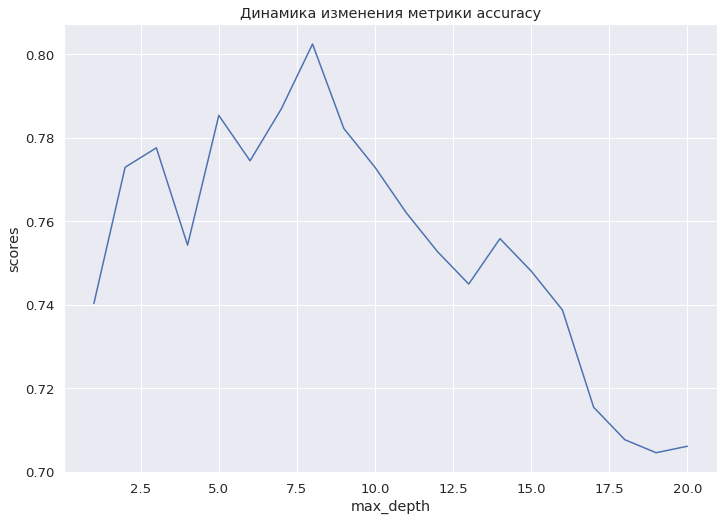

In [12]:
searcher_dtc = ParamsSearch(
    train_feature, train_target, valid_feature, valid_target,
    DecisionTreeClassifier
)
searcher_dtc.search_params(params={'max_depth':range(1,21)})

searcher_dtc.print_summary()

ax = sb.lineplot(data=searcher_dtc.report, x='max_depth', y='scores')
ax.set_title('Динамика изменения метрики accuracy')

dtc = searcher_dtc.model

Модель: RandomForestClassifier
Лучшая точность (accuracy%): 81.34%
Лучшие параметры:
    max_depth: 9
    n_estimators: 20


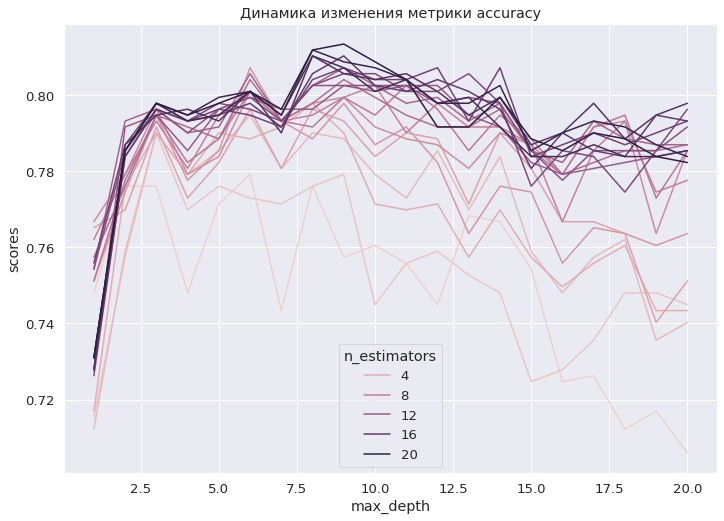

In [13]:
searcher_rfc = ParamsSearch(
    train_feature, train_target, valid_feature, valid_target,
    RandomForestClassifier
)
searcher_rfc.search_params(params={'max_depth':range(1,21), 'n_estimators': range(1,21)})

searcher_rfc.print_summary()

ax = sb.lineplot(data=searcher_rfc.report, y='scores', x='max_depth', hue='n_estimators')
ax.set_title('Динамика изменения метрики accuracy')

rfc = searcher_rfc.model

Модель: LogisticRegression
Лучшая точность (accuracy%): 74.34%
Лучшие параметры:
    l1_ratio: 0
    max_iter: 100
    multi_class: ovr
    penalty: elasticnet
    solver: saga


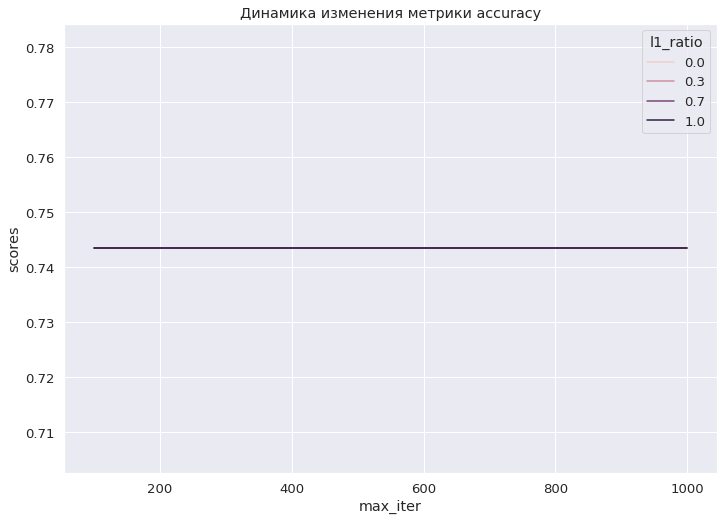

In [14]:
scaler = StandardScaler()

searcher_lr = ParamsSearch(
    scaler.fit_transform(train_feature), 
    train_target, 
    scaler.transform(valid_feature), 
    valid_target,
    LogisticRegression
)

searcher_lr.search_params(params={'penalty': ['elasticnet'],
                                  'solver': ['saga'],
                                  'multi_class': ['ovr'],
                                  'max_iter': [100, 500, 1000],
                                  'l1_ratio': [0, 1, .3, .7]})

ax = sb.lineplot(data=searcher_lr.report, y='scores', x='max_iter', hue='l1_ratio')
ax.set_title('Динамика изменения метрики accuracy')

searcher_lr.print_summary()

linear = searcher_lr.model

**Выводы**

- Рассмотрено три модели: DecisionTreeClassifier, RandomForestClassifier и LogisticRegression.
- Лучше всего показала себя модель случайного леса с параметрами max_depth: 9, n_estimators: 20. 1ое место.
- Хотя DecisionTreeClassifier совсем немного уступила RandomForestClassifier, обучается она быстрее. 2ое место. 
- Модель логистической регрессии получилось настроить до максимальной точности в 74.34% при обучении. И это оказался худший показатель среди рассмотренных. 3 место. 
- На графиках отражено поведение метрики accuracy относительно изменения параметров
- Протестированно наборов параметров 20 + 20*20 + 3*4 = 432

## Проверьте модель на тестовой выборке

In [15]:
print('Точность RandomForestClassifier: {:.2%}'.format(rfc.score(test_feature, test_target)))
print('Точность DecisionTreeClassifier: {:.2%}'.format(dtc.score(test_feature, test_target)))
print('Точность LogisticRegression: {:.2%}'.format(
    linear.score(
        scaler.transform(test_feature), 
        test_target
    )
))

Точность RandomForestClassifier: 81.03%
Точность DecisionTreeClassifier: 78.38%
Точность LogisticRegression: 74.96%


**Выводы**

- И снова победила модель случайного леса с параметрами max_depth: 9, n_estimators: 20. 
- Значение accuracy для RandomForestClassifier ниже относительно обучающей выборки на 0.31%. 
- Значение accuracy для DecisionTreeClassifier ниже относительно обучающей выборки на 2%. 
- В защиту LogisticRegression: модель показала состоятельность на тестовой выборке и показала большее значение точности, чем при обучении 74.96% vs 74.34%. Хотя до порога в 75% добраться так и не получилось.

## (бонус) Проверьте модели на адекватность

Построим случайную равновероятную модель предсказаний для сравнения с полученными выше моделями. А также для ответа на вопрос об адекватности.

In [16]:
# Dummy model uniform random predictions
rg = np.random.default_rng()
dumb_predictions = rg.integers(0, 2, size=len(test_target))
dumb_score = accuracy_score(dumb_predictions, test_target)

RFC_score = rfc.score(test_feature, test_target)
DTC_score = dtc.score(test_feature, test_target)
Linear_best_score = linear.score(
                        scaler.transform(test_feature), 
                        test_target
                    )

print('Точность равновероятной модели: {:.2%}'.format(dumb_score))
print()
print('Разница между accuracy моделей и accuracy равновероятной модели:')
print('RFC_score - dumb_score = {:.2%}'.format(RFC_score - dumb_score))
print('DTC_score - dumb_score = {:.2%}'.format(DTC_score - dumb_score))
print('Linear_best_score - dumb_score = {:.2%}'.format(Linear_best_score - dumb_score))

Точность равновероятной модели: 48.99%

Разница между accuracy моделей и accuracy равновероятной модели:
RFC_score - dumb_score = 32.04%
DTC_score - dumb_score = 29.39%
Linear_best_score - dumb_score = 25.97%


In [17]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(train_feature, train_target)
dumb_score = dummy.score(test_feature, test_target)


RFC_score = rfc.score(test_feature, test_target)
DTC_score = dtc.score(test_feature, test_target)
Linear_best_score = linear.score(
                        scaler.fit_transform(test_feature), 
                        test_target
                    )

print('Точность most_frequent модели: {:.2%}'.format(dumb_score))
print()
print('Разница между accuracy моделей и accuracy most_frequent модели:')
print('RFC_score - dumb_score = {:.2%}'.format(RFC_score - dumb_score))
print('DTC_score - dumb_score = {:.2%}'.format(DTC_score - dumb_score))
print('Linear_best_score - dumb_score = {:.2%}'.format(Linear_best_score - dumb_score))

Точность most_frequent модели: 69.36%

Разница между accuracy моделей и accuracy most_frequent модели:
RFC_score - dumb_score = 11.66%
DTC_score - dumb_score = 9.02%
Linear_best_score - dumb_score = 5.60%


Полученные модели отличаются от модели предсказывающей наиболее популярное значение максимум на 11.66% для RandomForestClassifier. При этом модель LogisticRegression ушла не далеко, опередив dummy всего на 5.6%.

##  Выводы

- Лучшая модель по итогам анализа: RandomForestClassifier с параметрами max_depth: 9, n_estimators: 20
- Модель RandomForestClassifier подтвердила свою состоятельность при проверке на тестовой выборке

model|valid accuracy|test accuracy
---|---|---
RandomForestClassifier|81.34%|81.03%

- Модель RandomForestClassifier работает явно лучше случайной равновероятной модели. Прошла проверку на адекватность дважды.

## Другой код с кроссвалидацией

При подходе с использованием кроссвалидации не нужно выделять валидационную выборку. Во время обучения вся обучающая выборка делится на k частей, каждая из которых по очереди играет роль валидационной, а остальные k-1 части используются для обучения модели.

In [18]:
feature = users_behavior.drop(columns=['is_ultra', 'calls'])
target = users_behavior['is_ultra']

train_feature, test_feature, train_target, test_target = train_test_split(
    feature,
    target,
    test_size=.2, 
    stratify=target,
    random_state=12345
)
split_summary(train_feature, train_target, 'train')
split_summary(test_feature, test_target, 'test')

Выборка: train
Размеры пространства feature: (2571, 3)
Размеры пространства target: (2571,)
Доли классов target:
    target class: 0 fraction: 0.69
    target class: 1 fraction: 0.31

Выборка: test
Размеры пространства feature: (643, 3)
Размеры пространства target: (643,)
Доли классов target:
    target class: 0 fraction: 0.69
    target class: 1 fraction: 0.31



Для поиска лучших параметров можно воспользоваться классом GridSearchCV. Он ищет лучшую комбинацию параметров среди указанных в аргументе params значений, при этом, глядя в документацию, для нашего случая по умолчанию используется стратифицированная кроссвалидация. Т.е. применяется StratifiedKFold итератор.

In [19]:
dtc = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=12345),
    param_grid={'max_depth': range(1, 21)},
    cv=5, n_jobs=-1
)
dtc.fit(train_feature, train_target)

print('Best score: {:.2%}'.format(dtc.best_score_))
print('Best parameters:')
print(*("    {}: {}".format(k, v) for k, v in dtc.best_params_.items()), sep='\n')

Best score: 79.00%
Best parameters:
    max_depth: 7


In [20]:
rfc = GridSearchCV(
    estimator=RandomForestClassifier(random_state=12345),
    param_grid={'n_estimators': range(1, 21),
                'max_depth': range(1, 21)}, 
    cv=5, n_jobs=-1
)
rfc.fit(train_feature, train_target)

print('Best score: {:.2%}'.format(rfc.best_score_))
print('Best parameters:')
print(*("    {}: {}".format(k, v) for k, v in rfc.best_params_.items()), sep='\n')

Best score: 80.13%
Best parameters:
    max_depth: 8
    n_estimators: 9


Параметры несколько отличаются от полученных без кроссвалидации, а значения метрик приблизительно такое же.

In [21]:
print('Точность RandomForestClassifier: {:.2%}'.format(rfc.score(test_feature, test_target)))

Точность RandomForestClassifier: 80.56%


In [22]:
print('Точность DecisionTreeClassifier: {:.2%}'.format(dtc.score(test_feature, test_target)))

Точность DecisionTreeClassifier: 79.47%


- Точность моделей при обучении с кроссвалидацией на тестовой выборке превышает значение на обучающей. Обучились лучше.
- Если удалить колонку calls точноть немного повышается. Примерно на 0.3%
- Обе модели подтвеждают свою состоятельность на тестовой выборке

Можно даже мегаотчет посмотреть на примере RandomForestClassifier...

In [23]:
rfc_cvreport = pd.DataFrame(rfc.cv_results_)
rfc_cvreport

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009189,0.004986,0.003417,0.000181,1,1,"{'max_depth': 1, 'n_estimators': 1}",0.724272,0.735409,0.749027,0.702335,0.715953,0.725399,0.016006,397
1,0.008476,0.000110,0.003394,0.000037,1,2,"{'max_depth': 1, 'n_estimators': 2}",0.751456,0.791829,0.762646,0.741245,0.743191,0.758073,0.018487,353
2,0.010439,0.000116,0.003699,0.000137,1,3,"{'max_depth': 1, 'n_estimators': 3}",0.739806,0.772374,0.764591,0.745136,0.745136,0.753409,0.012701,359
3,0.016734,0.002885,0.005323,0.000637,1,4,"{'max_depth': 1, 'n_estimators': 4}",0.747573,0.785992,0.764591,0.749027,0.745136,0.758464,0.015367,351
4,0.023234,0.000289,0.006268,0.000176,1,5,"{'max_depth': 1, 'n_estimators': 5}",0.737864,0.747082,0.739300,0.717899,0.725681,0.733565,0.010408,392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.068671,0.001147,0.007638,0.000338,20,16,"{'max_depth': 20, 'n_estimators': 16}",0.753398,0.785992,0.828794,0.760700,0.789883,0.783754,0.026548,242
396,0.072083,0.000512,0.007642,0.000178,20,17,"{'max_depth': 20, 'n_estimators': 17}",0.751456,0.791829,0.828794,0.760700,0.787938,0.784143,0.027148,237
397,0.075040,0.001213,0.007944,0.000228,20,18,"{'max_depth': 20, 'n_estimators': 18}",0.763107,0.791829,0.830739,0.764591,0.793774,0.788808,0.024654,168
398,0.080519,0.000442,0.008133,0.000289,20,19,"{'max_depth': 20, 'n_estimators': 19}",0.755340,0.787938,0.822957,0.762646,0.795720,0.784920,0.024264,226
